In [1]:
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (13, 4)
plt.style.use('ggplot')

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation

In [2]:
train = DataSet('/home/harllan/nilmtk/data/LAB_active/lab_powerActive.h5')
test = DataSet('/home/harllan/nilmtk/data/LAB_active/lab_powerActive.h5')
#A casa utilizada do banco LAB
building = 1

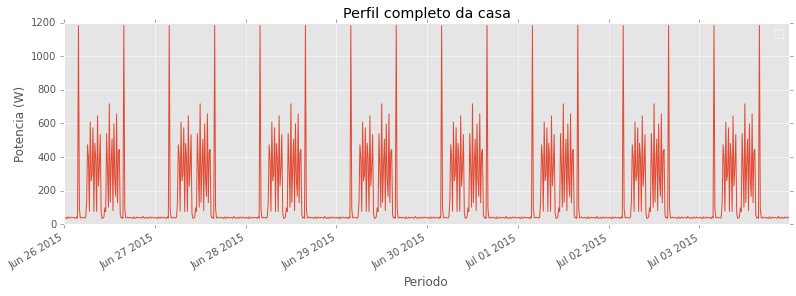

In [3]:
#Gráfico completo da casa
train.buildings[building].elec.mains().plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Perfil completo da casa");
plt.legend('')

In [4]:
#Divide a base: uma parte para treinamento e a outra para teste (desagregação)
#Treinamento termina em 
train.set_window(end="30-6-2015")
#Teste inicia em 
test.set_window(start="30-6-2015")

train_elec = train.buildings[building].elec
test_elec = test.buildings[building].elec

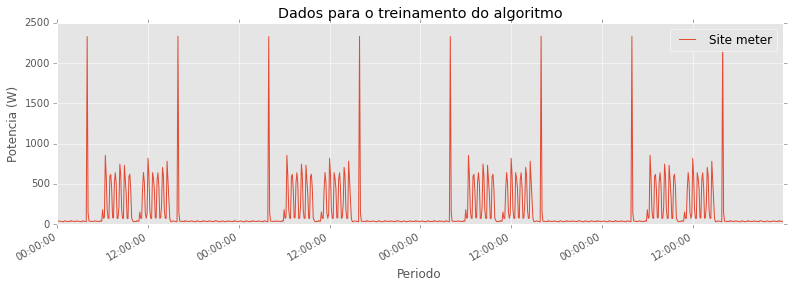

In [5]:
#Gráfico da base de treinamento
train_elec.mains().plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados para o treinamento do algoritmo");

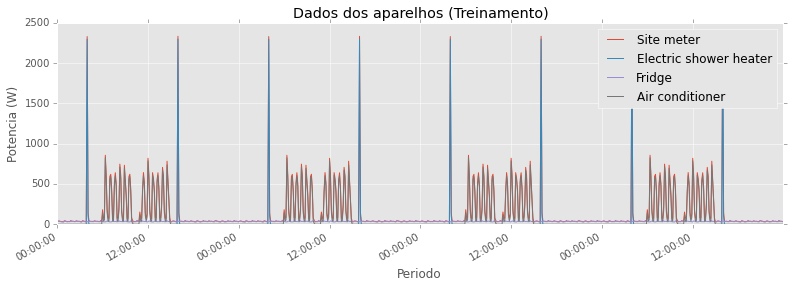

In [6]:
train_elec.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados dos aparelhos (Treinamento)");

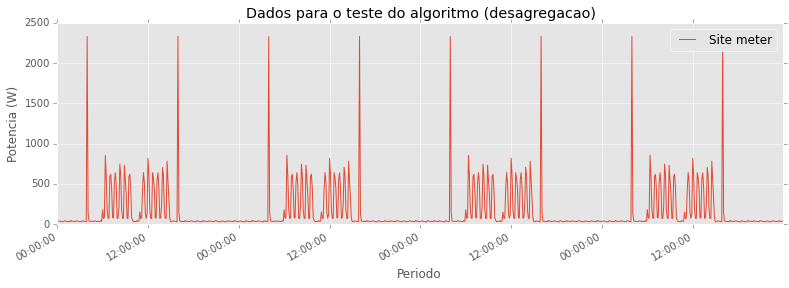

In [7]:
#Gráfico da base de teste (que pretende desagregar)
test_elec.mains().plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados para o teste do algoritmo (desagregacao)");

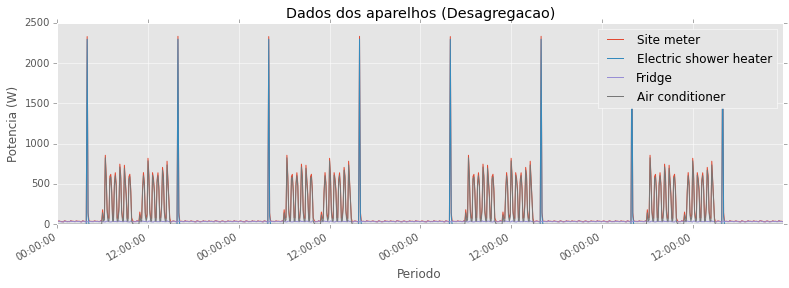

In [8]:
test_elec.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados dos aparelhos (Desagregacao)");

In [9]:
#Selecionando top-3 aparelhos em termos de consumo de energia, que serão usados para treinar os algoritmos
top_3_train_elec = train_elec.submeters().select_top_k(k=3)

3/3 ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])

In [10]:
top_3_train_elec

MeterGroup(meters=
  ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=3, building=1, dataset='LAB', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=2, building=1, dataset='LAB', appliances=[Appliance(type='electric shower heater', instance=1)])
)

In [11]:
#FHMM
from nilmtk.disaggregate import fhmm_exact
#Arquivo onde vai ficar os dados da desagregação
disag_filename = '/home/harllan/nilmtk/data/LAB_active/lab-disag-fhmm-4seg.h5'

#Treinando o algoritmo FHMM com uma frequência de 4 segundos
start=time.time()
fhmm = fhmm_exact.FHMM()
fhmm.train(top_3_train_elec, sample_period=4)
end=time.time()
#Tempo de treinamento do algoritmo
print('Time Train: ' + str(end-start))

#Desagregando os dados, também para uma frequência de 4 segundos
start=time.time()
#Coloca em HDF
output = HDFDataStore(disag_filename, 'w')
fhmm.disaggregate(test_elec.mains(), output, sample_period=4)
output.close()
end=time.time()
#Tempo de desagregação
print('Time Disag: ' + str(end-start))

Training model for submeter 'ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='LAB', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='LAB', appliances=[Appliance(type='electric shower heater', instance=1)])'
Time Train: 22.8904719353
Time Disag: 0.300400018692


In [12]:
disag_fhmm = DataSet(disag_filename)
disag_fhmm_elec = disag_fhmm.buildings[building].elec

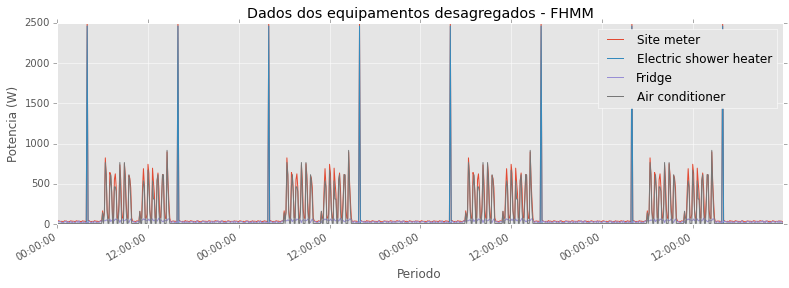

In [13]:
#Equipamentos desagregados
disag_fhmm_elec.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados dos equipamentos desagregados - FHMM");

In [14]:
#total (consumo) de energia real (dados agregados)
energy_per_meter = test_elec.submeters().energy_per_meter().max()
sum_test = energy_per_meter.sum()
sum_test

3/3 ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])

15.63062

In [15]:
#total (consumo) de energia após desagregação (dados agregados)
energy_per_meter_disag = disag_fhmm_elec.submeters().energy_per_meter().max()
disag_fhmm_energy = energy_per_meter_disag.sum()
disag_fhmm_energy

3/3 ElecMeter(instance=4, building=1, dataset='NILMTK_FHMM_2015-08-11T23:33:54', appliances=[Appliance(type='air conditioner', instance=1)])

15.292133333333332

In [16]:
fridge_disag = disag_fhmm_elec['fridge']
fridge_test = test_elec['fridge']

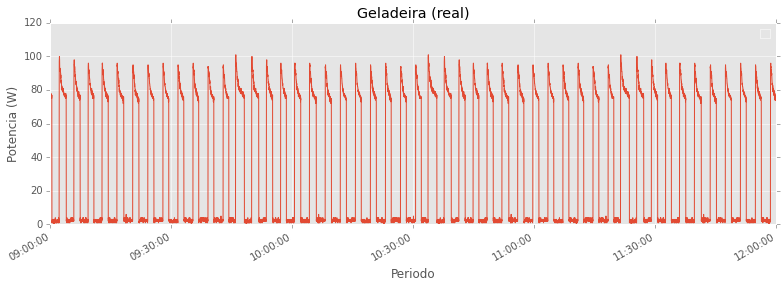

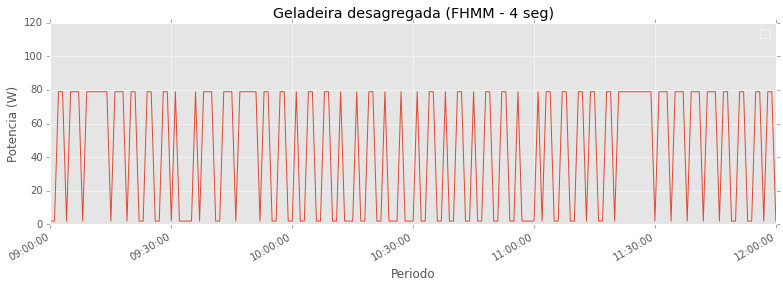

In [17]:
#Geladeira antes da desagregação (dados reais)
fridge_test_df = fridge_test.load().next()
fridge_test_df["2015-07-01 09:00:00":"2015-07-01 12:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Geladeira (real)");
plt.legend('');

#Geladeira após desagregação
fridge_disag_df = fridge_disag.load().next()
fridge_disag_df["2015-07-01 09:00:00":"2015-07-01 12:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.ylim(0,120)
plt.title("Geladeira desagregada (FHMM - 4 seg)");
plt.legend('');

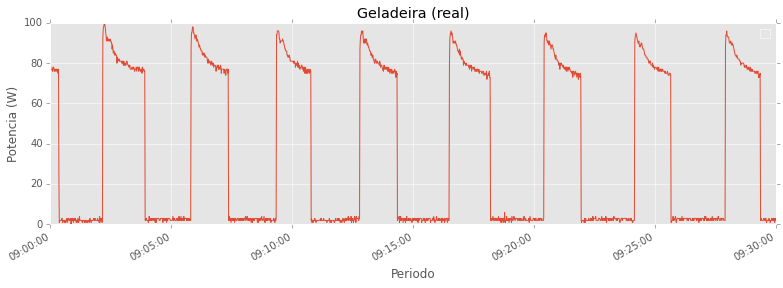

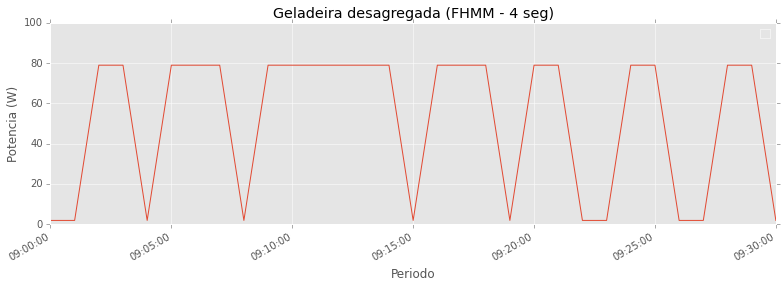

In [18]:
#Geladeira antes da desagregação (dados reais)
fridge_test_df = fridge_test.load().next()
fridge_test_df["2015-07-01 09:00:00":"2015-07-01 09:30:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Geladeira (real)");
plt.legend('');

#Geladeira após desagregação
fridge_disag_df = fridge_disag.load().next()
fridge_disag_df["2015-07-01 09:00:00":"2015-07-01 09:30:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.ylim(0,100)
plt.title("Geladeira desagregada (FHMM - 4 seg)");
plt.legend('');

In [19]:
#potência real da geladeira
fridge_test = test_elec['fridge']
total_fridge_test_energy = fridge_test.total_energy(full_results=True)
type(total_fridge_test_energy)
total_fridge_test_energy

                             active                        end
2015-06-30 00:00:00-03:00  3.491349  2015-07-03 23:59:58-03:00

In [20]:
#potência após desagregação da geladeira
fridge_disag = disag_fhmm_elec['fridge']
total_fridge_disag_energy = fridge_disag.total_energy(full_results=True)
type(total_fridge_disag_energy)
total_fridge_disag_energy

                            active                        end
2015-06-30 00:00:00-03:00  3.57355  2015-07-03 23:59:00-03:00

In [21]:
shower_test = test_elec['electric shower heater']
shower_disag = disag_fhmm_elec['electric shower heater']

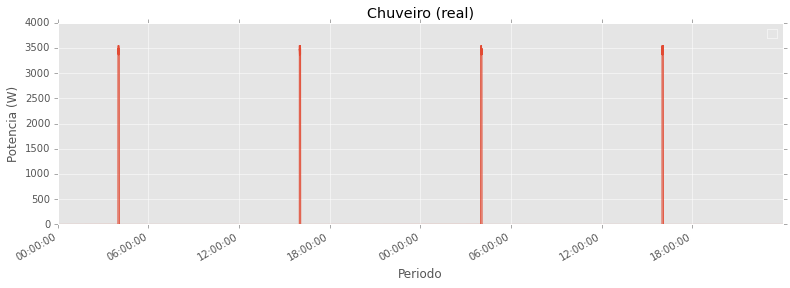

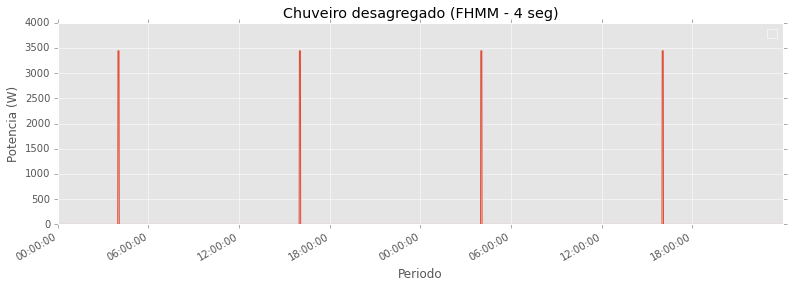

In [22]:
#Chuveiro antes da desagregação (dados reais)
shower_test_df = shower_test.load().next()
shower_test_df["2015-07-01":"2015-07-02"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Chuveiro (real)");
plt.legend('');

#Chuveiro após desagregação
shower_disag_df = shower_disag.load().next()
shower_disag_df["2015-07-01":"2015-07-02"].plot()
plt.ylim(0,4000)
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Chuveiro desagregado (FHMM - 4 seg)");
plt.legend('');

In [23]:
#potência real do chuveiro
shower_test = test_elec['electric shower heater']
total_shower_test_energy = shower_test.total_energy(full_results=True)
type(total_shower_test_energy)
total_shower_test_energy

                             active                        end
2015-06-30 00:00:00-03:00  2.312189  2015-07-03 23:59:58-03:00

In [24]:
#potência após desagregação do chuveiro
shower_disag = disag_fhmm_elec['electric shower heater']
total_shower_disag_energy = shower_disag.total_energy(full_results=True)
type(total_shower_disag_energy)
total_shower_disag_energy

                             active                        end
2015-06-30 00:00:00-03:00  2.296667  2015-07-03 23:59:00-03:00

In [25]:
#Ar-condicionado
air_test = test_elec['air conditioner']
air_disag = disag_fhmm_elec['air conditioner']

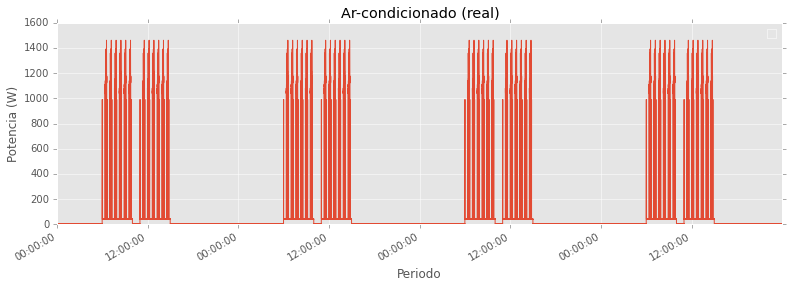

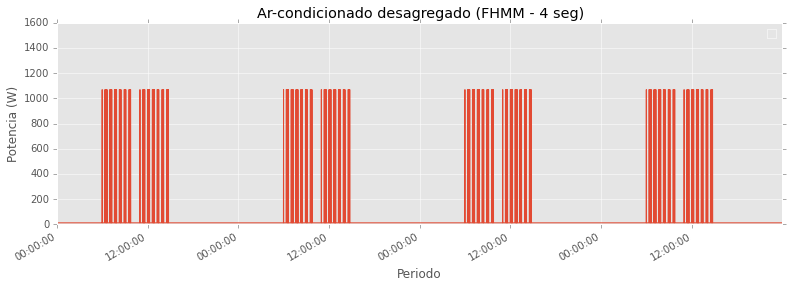

In [26]:
#Ar-condicionado antes da desagregação (dados reais)
air_test_df = air_test.load().next()
air_test_df.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado (real)");
plt.legend('');

#Ar-condicionado após desagregação
air_disag_df = air_disag.load().next()
air_disag_df.plot()
plt.ylim(0,1600)
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado desagregado (FHMM - 4 seg)");
plt.legend('');

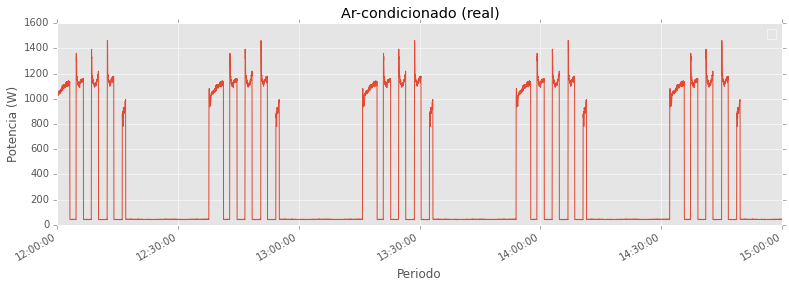

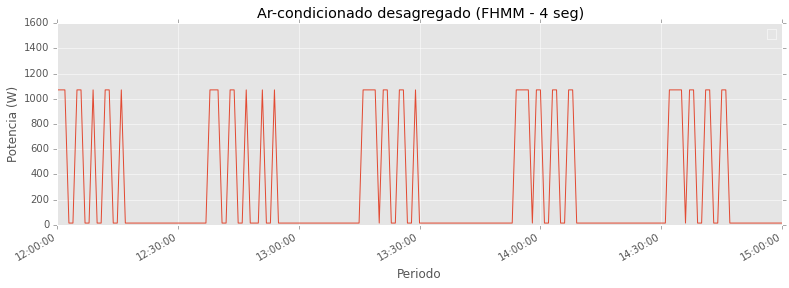

In [27]:
#Ar-condicionado antes da desagregação (dados reais)
air_test_df = air_test.load().next()
air_test_df["2015-07-01 12:00:00":"2015-07-01 15:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado (real)");
plt.legend('');

#Ar-condicionado após desagregação
air_disag_df = air_disag.load().next()
air_disag_df["2015-07-01 12:00:00":"2015-07-01 15:00:00"].plot()
plt.ylim(0,1600)
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado desagregado (FHMM - 4 seg)");
plt.legend('');

In [28]:
#potência real do ar-condicionado
air_test = test_elec['air conditioner']
total_air_test_energy = air_test.total_energy(full_results=True)
type(total_air_test_energy)
total_air_test_energy

                             active                        end
2015-06-30 00:00:00-03:00  9.827082  2015-07-03 23:59:58-03:00

In [29]:
#potência após desagregação do ar-condicionado
air_disag = disag_fhmm_elec['air conditioner']
total_air_disag_energy = air_disag.total_energy(full_results=True)
type(total_air_disag_energy)
total_air_disag_energy

                             active                        end
2015-06-30 00:00:00-03:00  9.421917  2015-07-03 23:59:00-03:00

In [30]:
#Métrica f-score, onde é retornado uma pontuação entre 0 e 1. Valor próximo à 1, significa uma boa acurácia do algoritmo.
from nilmtk.metrics import f1_score
f1_fhmm = f1_score(disag_fhmm_elec, test_elec)
f1_fhmm.index = disag_fhmm_elec.get_labels(f1_fhmm.index)

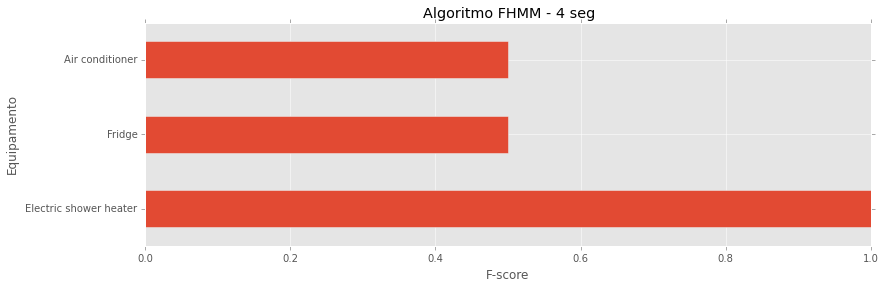

In [31]:
f1_fhmm.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('F-score');
plt.title("Algoritmo FHMM - 4 seg");

In [32]:
f1_fhmm

Electric shower heater    1.000000
Fridge                    0.500140
Air conditioner           0.500065
dtype: float64

In [33]:
from nilmtk.metrics import fraction_energy_assigned_correctly
fte_fhmm = fraction_energy_assigned_correctly(disag_fhmm_elec, test_elec)
fte_fhmm

3/3 ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])

0.98742124283862198

In [34]:
#Métrica MNE. Representa o erro e quanto menor o seu valor, melhor é a precisão da desagregação.
from nilmtk.metrics import mean_normalized_error_power
mne_fhmm = mean_normalized_error_power(disag_fhmm_elec, test_elec)
mne_fhmm.index = disag_fhmm_elec.get_labels(mne_fhmm.index)

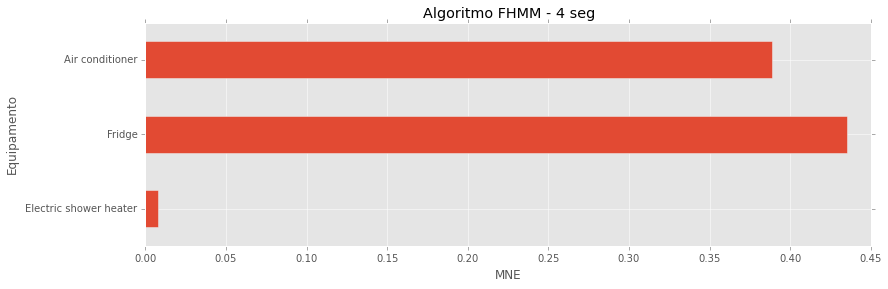

In [35]:
mne_fhmm.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('MNE');
plt.title("Algoritmo FHMM - 4 seg");

In [36]:
mne_fhmm

Electric shower heater    0.008084
Fridge                    0.435396
Air conditioner           0.388783
dtype: float64

In [37]:
#Métrica RMS. Representa o erro e quanto menor o seu valor, melhor é a precisão da desagregação.
from nilmtk.metrics import rms_error_power
rms_fhmm = rms_error_power(disag_fhmm_elec, test_elec)
rms_fhmm.index = disag_fhmm_elec.get_labels(rms_fhmm.index)

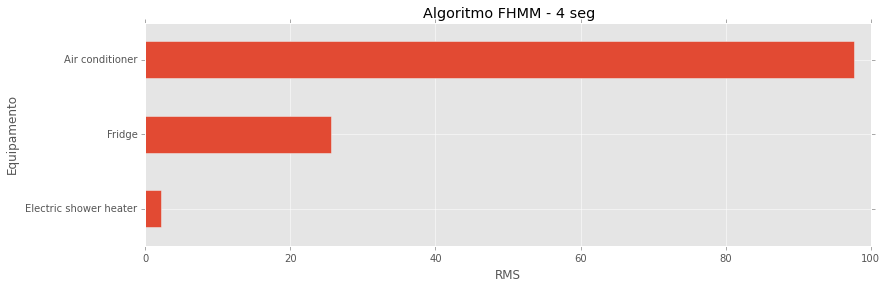

In [38]:
rms_fhmm.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('RMS');
plt.title("Algoritmo FHMM - 4 seg");

In [39]:
rms_fhmm

Electric shower heater     2.202815
Fridge                    25.615021
Air conditioner           97.737340
dtype: float64

In [40]:
#Métricas
#Arquivo com os resultados da métricas
path = '/home/harllan/Documentos/NILMTK_Disag/LAB_Tests/metrics_equip.txt'
result = ''

result = 'Fridge,4,FHMM,' + str(f1_fhmm['Fridge']) + ',' + str(mne_fhmm['Fridge']) + ',' + str(rms_fhmm['Fridge'])
result = result + '\n'
result = result + 'Shower,4,FHMM,' + str(f1_fhmm['Electric shower heater']) + ',' + str(mne_fhmm['Electric shower heater']) + ',' + str(rms_fhmm['Electric shower heater'])
result = result + '\n'
result = result + 'Air-conditioner,4,FHMM,' + str(f1_fhmm['Air conditioner']) + ',' + str(mne_fhmm['Air conditioner']) + ',' + str(rms_fhmm['Air conditioner'])

#Escrevendo em arquivo.txt
#'a' é de append, adiciona sem apagar o que já tem no arquivo
arquivo = open(path, 'a')
arquivo.write('\n')
arquivo.write(result)
arquivo.close()

In [41]:
#CO
from nilmtk.disaggregate import CombinatorialOptimisation
#Arquivo onde vai ficar os dados da desagregação
disag_filename = '/home/harllan/nilmtk/data/LAB_active/lab-disag-co-4seg.h5'

#Treinando o algoritmo CO com uma frequência de 4 segundos
start=time.time()
co = CombinatorialOptimisation()
co.train(top_3_train_elec, sample_period=4)
end=time.time()
#Tempo de treinamento do algoritmo
print('Time train: ' + str(end-start))

#Desagregando os dados, também para uma frequência de 4 segundos
start=time.time()
#Coloca em HDF
output = HDFDataStore(disag_filename, 'w')
co.disaggregate(test_elec.mains(), output, sample_period=4)
output.close()
end=time.time()
#Tempo de desagregação
print('Time disag: ' + str(end-start))

Training model for submeter 'ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='LAB', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='LAB', appliances=[Appliance(type='electric shower heater', instance=1)])'
Done training!
Time train: 1.41300415993
vampire_power = 0.0 watts
Estimating power demand for 'ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='LAB', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='LAB', appliances=[Appliance(type='electric shower heater', instance=1)])'
Time disag: 0.419367074966


In [42]:
disag_co = DataSet(disag_filename)
disag_co_elec = disag_co.buildings[building].elec

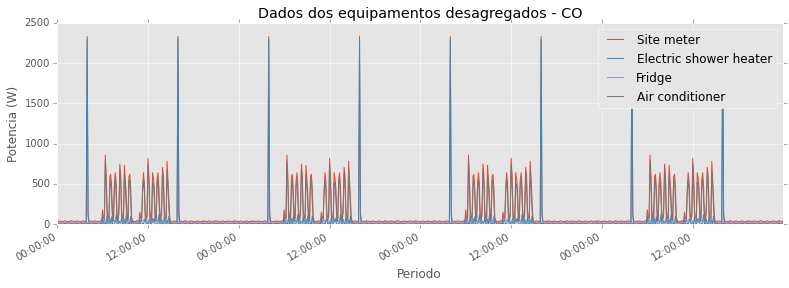

In [43]:
#Equipamentos desagregados
disag_co_elec.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Dados dos equipamentos desagregados - CO");

In [44]:
#total (consumo) de energia real (dados agregados)
energy_per_meter = test_elec.submeters().energy_per_meter().max()
sum_test = energy_per_meter.sum()
sum_test

3/3 ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])

15.63062

In [45]:
#total (consumo) de energia após desagregação (dados agregados)
energy_per_meter_disag_co = disag_co_elec.submeters().energy_per_meter().max()
disag_co_energy = energy_per_meter_disag_co.sum()
disag_co_energy

3/3 ElecMeter(instance=4, building=1, dataset='NILMTK_CO_2015-08-11T23:34:11', appliances=[Appliance(type='air conditioner', instance=1)])

15.297124444444444

In [46]:
fridge_test = test_elec['fridge']
fridge_disag_co = disag_co_elec['fridge']

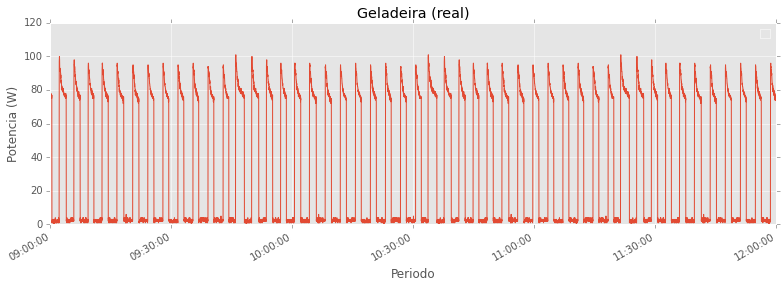

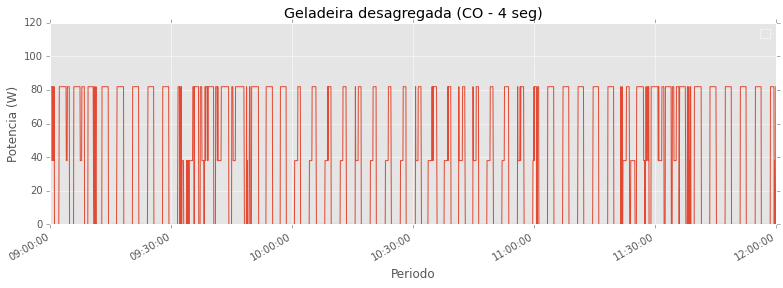

In [47]:
#Geladeira antes da desagregação (dados reais)
fridge_test_df = fridge_test.load().next()
fridge_test_df["2015-07-01 09:00:00":"2015-07-01 12:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Geladeira (real)");
plt.legend('');

#Geladeira após desagregação
fridge_disag_co_df = fridge_disag_co.load().next()
fridge_disag_co_df["2015-07-01 09:00:00":"2015-07-01 12:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.ylim(0,120)
plt.title("Geladeira desagregada (CO - 4 seg)");
plt.legend('');

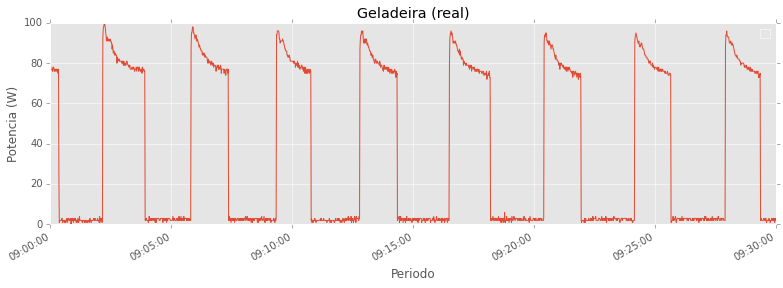

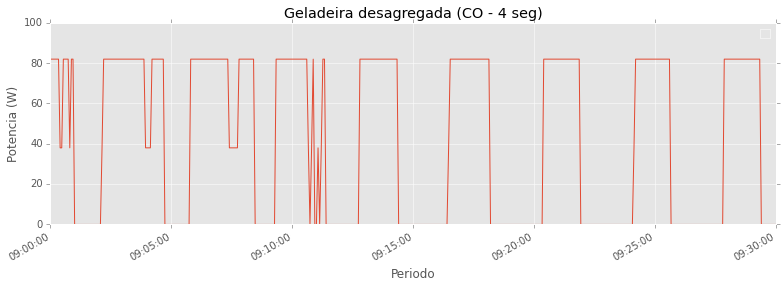

In [48]:
#Geladeira antes da desagregação (dados reais)
fridge_test_df = fridge_test.load().next()
fridge_test_df["2015-07-01 09:00:00":"2015-07-01 09:30:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Geladeira (real)");
plt.legend('');

#Geladeira após desagregação
fridge_disag_co_df = fridge_disag_co.load().next()
fridge_disag_co_df["2015-07-01 09:00:00":"2015-07-01 09:30:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.ylim(0,100)
plt.title("Geladeira desagregada (CO - 4 seg)");
plt.legend('');

In [49]:
#potência real da geladeira
fridge_test = test_elec['fridge']
total_fridge_test_energy = fridge_test.total_energy(full_results=True)
type(total_fridge_test_energy)
total_fridge_test_energy

                             active                        end
2015-06-30 00:00:00-03:00  3.491349  2015-07-03 23:59:58-03:00

In [50]:
#potência após desagregação da geladeira
fridge_disag_co = disag_co_elec['fridge']
total_fridge_disag_co_energy = fridge_disag_co.total_energy(full_results=True)
type(total_fridge_disag_co_energy)
total_fridge_disag_co_energy

                             active                        end
2015-06-30 00:00:00-03:00  2.952702  2015-07-03 23:59:56-03:00

In [51]:
shower_test = test_elec['electric shower heater']
shower_disag_co = disag_co_elec['electric shower heater']

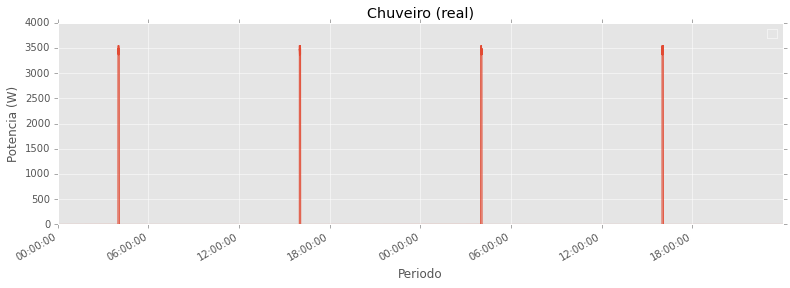

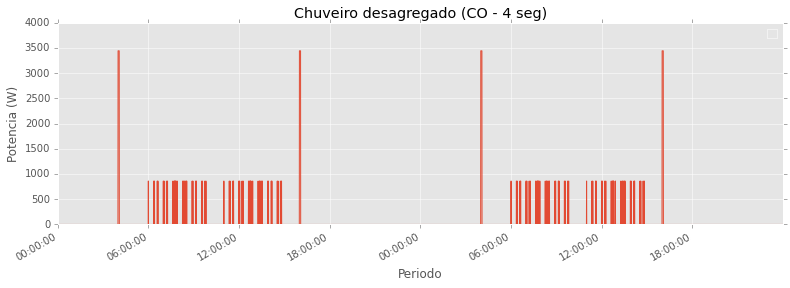

In [52]:
#Chuveiro antes da desagregação (dados reais)
shower_test_df = shower_test.load().next()
shower_test_df["2015-07-01":"2015-07-02"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Chuveiro (real)");
plt.legend('');

#Chuveiro após desagregação
shower_disag_co_df = shower_disag_co.load().next()
shower_disag_co_df["2015-07-01":"2015-07-02"].plot()
plt.ylim(0,4000)
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Chuveiro desagregado (CO - 4 seg)");
plt.legend('');

In [53]:
#potência real do chuveiro
shower_test = test_elec['electric shower heater']
total_shower_test_energy = shower_test.total_energy(full_results=True)
type(total_shower_test_energy)
total_shower_test_energy

                             active                        end
2015-06-30 00:00:00-03:00  2.312189  2015-07-03 23:59:58-03:00

In [54]:
#potência após desagregação do chuveiro
shower_disag_co = disag_co_elec['electric shower heater']
total_shower_disag_co_energy = shower_disag_co.total_energy(full_results=True)
type(total_shower_disag_co_energy)
total_shower_disag_co_energy

                             active                        end
2015-06-30 00:00:00-03:00  3.283947  2015-07-03 23:59:56-03:00

In [55]:
#Ar-condicionado
air_test = test_elec['air conditioner']
air_disag_co = disag_co_elec['air conditioner']

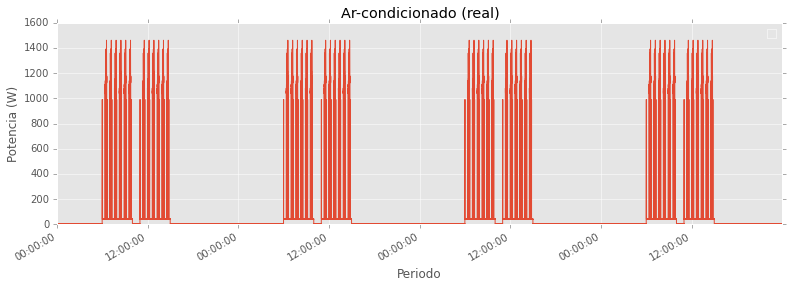

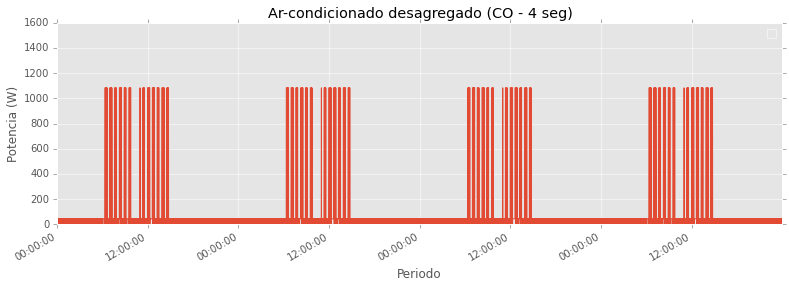

In [56]:
#Ar-condicionado antes da desagregação (dados reais)
air_test_df = air_test.load().next()
air_test_df.plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado (real)");
plt.legend('');

#Ar-condicionado após desagregação
air_disag_co_df = air_disag_co.load().next()
air_disag_co_df.plot()
plt.ylim(0,1600)
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado desagregado (CO - 4 seg)");
plt.legend('');

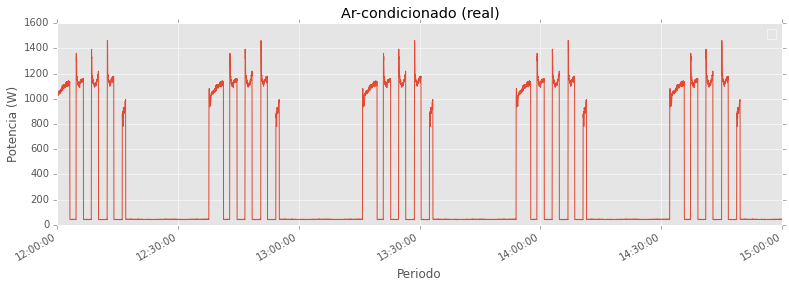

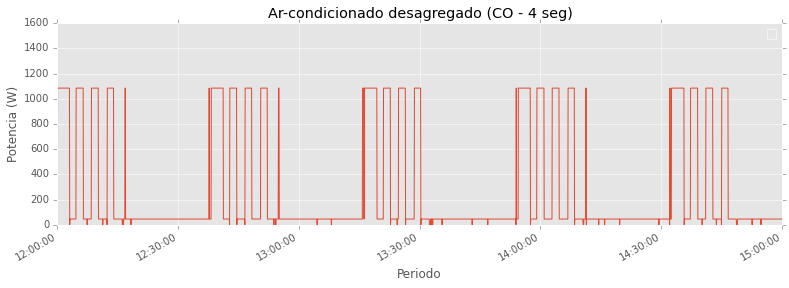

In [57]:
#Ar-condicionado antes da desagregação (dados reais)
air_test_df = air_test.load().next()
air_test_df["2015-07-01 12:00:00":"2015-07-01 15:00:00"].plot()
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado (real)");
plt.legend('');

#Ar-condicionado após desagregação
air_disag_co_df = air_disag_co.load().next()
air_disag_co_df["2015-07-01 12:00:00":"2015-07-01 15:00:00"].plot()
plt.ylim(0,1600)
plt.ylabel('Potencia (W)');
plt.xlabel('Periodo');
plt.title("Ar-condicionado desagregado (CO - 4 seg)");
plt.legend('');

In [58]:
#potência real do ar-condicionado
air_test = test_elec['air conditioner']
total_air_test_energy = air_test.total_energy(full_results=True)
type(total_air_test_energy)
total_air_test_energy

                             active                        end
2015-06-30 00:00:00-03:00  9.827082  2015-07-03 23:59:58-03:00

In [59]:
#potência após desagregação do ar-condicionado
air_disag_co = disag_co_elec['air conditioner']
total_air_disag_co_energy = air_disag_co.total_energy(full_results=True)
type(total_air_disag_co_energy)
total_air_disag_co_energy

                             active                        end
2015-06-30 00:00:00-03:00  9.060476  2015-07-03 23:59:56-03:00

In [60]:
#Métrica f-score, para o algoritmo CO.
from nilmtk.metrics import f1_score
f1_co= f1_score(disag_co_elec, test_elec)
f1_co.index = disag_co_elec.get_labels(f1_co.index)

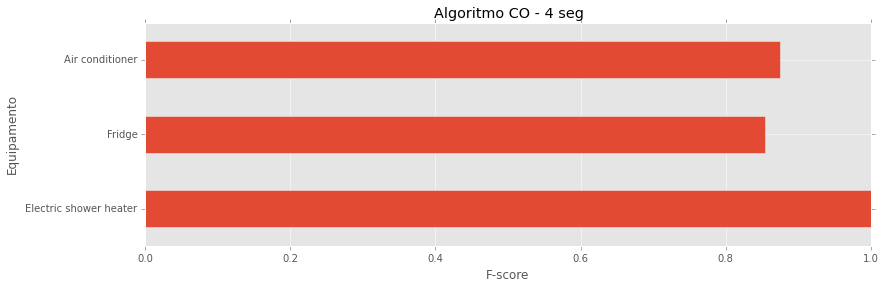

In [61]:
f1_co.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('F-score');
plt.title("Algoritmo CO - 4 seg");

In [62]:
f1_co

Electric shower heater    1.000000
Fridge                    0.854331
Air conditioner           0.875437
dtype: float64

In [63]:
from nilmtk.metrics import fraction_energy_assigned_correctly
fte_co = fraction_energy_assigned_correctly(disag_co_elec, test_elec)
fte_co

3/3 ElecMeter(instance=4, building=1, dataset='LAB', appliances=[Appliance(type='air conditioner', instance=1)])

0.93324949801101453

In [64]:
#Métrica MNE.
from nilmtk.metrics import mean_normalized_error_power
mne_co = mean_normalized_error_power(disag_co_elec, test_elec)
mne_co.index = disag_co_elec.get_labels(mne_co.index)

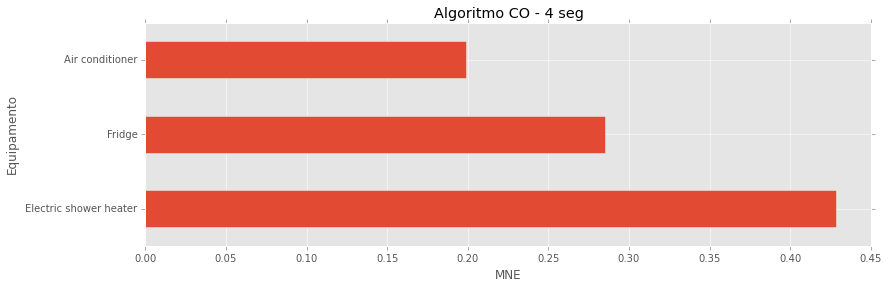

In [65]:
mne_co.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('MNE');
plt.title("Algoritmo CO - 4 seg");

In [66]:
mne_co

Electric shower heater    0.428171
Fridge                    0.285144
Air conditioner           0.198967
dtype: float64

In [67]:
#Métrica RMS.
from nilmtk.metrics import rms_error_power
rms_co = rms_error_power(disag_co_elec, test_elec)
rms_co.index = disag_co_elec.get_labels(rms_co.index)

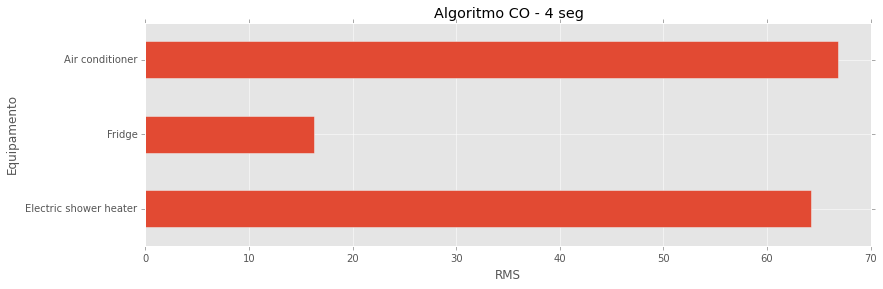

In [68]:
rms_co.plot(kind='barh')
plt.ylabel('Equipamento');
plt.xlabel('RMS');
plt.title("Algoritmo CO - 4 seg");

In [69]:
rms_co

Electric shower heater    64.236203
Fridge                    16.269677
Air conditioner           66.817719
dtype: float64

In [70]:
#Métricas
#Arquivo com os resultados das métricas
path = '/home/harllan/Documentos/NILMTK_Disag/LAB_Tests/metrics_equip.txt'
result = ''

result = 'Fridge,4,CO,' + str(f1_co['Fridge']) + ',' + str(mne_co['Fridge']) + ',' + str(rms_co['Fridge'])
result = result + '\n'
result = result + 'Shower,4,CO,' + str(f1_co['Electric shower heater']) + ',' + str(mne_co['Electric shower heater']) + ',' + str(rms_co['Electric shower heater'])
result = result + '\n'
result = result + 'Air-conditioner,4,CO,' + str(f1_co['Air conditioner']) + ',' + str(mne_co['Air conditioner']) + ',' + str(rms_co['Air conditioner'])

#Escrevendo em arquivo.txt
#'a' é de append, adiciona sem apagar o que já tem no arquivo
arquivo = open(path, 'a')
arquivo.write('\n')
arquivo.write(result)
arquivo.close()